In [16]:
import torch
import torchmin.bfgs as bfs
import matplotlib.pyplot as plt
import numpy as np

import torchmin.benchmarks as bm

In [17]:
batchsize=128
DIM=10

In [18]:
USE_CUDA=False
if torch.cuda.is_available():
    USE_CUDA=True
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_CUDA

True

## Define objective function
Considering linear search is useful, we define 2 kinds of loss funtion.<br>
- loss for each samples in this batch
- mean loss for this batch

In [19]:
# 定义一个二次函数作为例子
def f(W,Y,x):
    """quadratic function : f(\theta) = \|W\theta - y\|_2^2"""
    if USE_CUDA:
        W = W.cuda()
        Y = Y.cuda()
        x = x.cuda()

    return ((torch.matmul(W,x.unsqueeze(-1)).squeeze()-Y)**2).sum(dim=1)

def loss_f(W,Y,x):
    """quadratic function : f(\theta) = \|W\theta - y\|_2^2"""
    if USE_CUDA:
        W = W.cuda()
        Y = Y.cuda()
        x = x.cuda()

    return ((torch.matmul(W,x.unsqueeze(-1)).squeeze()-Y)**2).sum(dim=1).mean(dim=0)

def logistic(A,b,x,lamb,n):
    sig=torch.sigmoid(torch.matmul(A,x.unsqueeze(-1)).squeeze())
    return (-b*torch.log(sig)+(1-b)*torch.log(1-sig)).mean(dim=1)+lamb/n*torch.norm(x,dim=-1)


In [20]:
class loss_function:
    def __init__(self,batchsize,DIM,device,parameter=None,problem='MS'):
        if not parameter:
            self.W = torch.randn((batchsize, DIM, DIM), device=device) # represents IID
            self.Y = torch.randn((batchsize,DIM),device=device)
            
    def value(x):
        return ((torch.matmul(W,x.unsqueeze(-1)).squeeze()-Y)**2).sum(dim=1)
    
    def rand_reset():
        self.W = torch.randn((batchsize, DIM, DIM), device=device)
        self.Y = torch.randn((batchsize,DIM),device=device)


## BFGS update iteration

In [21]:
class BFGS:
    def __init__(self,batchsize,DIM,device):
        self.I = torch.eye(DIM, device=x.device, dtype=x.dtype,requires_grad=True).unsqueeze(0).expand(batchsize, -1, -1)
        self.H = self.I.clone()
    def H_BFDS_update(self,s,y):
        st=s.unsqueeze(1)
        s=s.unsqueeze(2)
        yt=y.unsqueeze(1)
        y=y.unsqueeze(2)
        sy=torch.matmul(s,yt)
        ss=torch.matmul(s,st)
        yst=torch.matmul(y,st)
        yts=torch.matmul(yt,s)
        #print(yts.min())
        yHy=torch.matmul(torch.matmul(yt,self.H),y)
        self.H=self.H-(torch.matmul(sy,self.H)+torch.matmul(self.H,yst))/yts+(yHy/yts+1)*ss/yts
        #print(self.H)

## Linear search (Strong Wolfe)

In [22]:
import torch

def strong_wolfe(W,Y,batchsize,f, x, step_dir, loss, grad, device, c1=1e-4, c2=0.9, max_iter=10):
    """
    Strong Wolfe Line Search
    Args:
    - f: Function to be optimized
    - x: Current point
    - step_dir: Search direction
    - loss: Loss at current point
    - grad: Gradient at current point
    - c1: Armijo condition parameter
    - c2: Curvature condition parameter
    - max_iter: Maximum number of iterations

    Returns:
    - step_size: Calculated step size
    """

    # Initialize step size
    step_size = torch.ones((128,1),device=device)
    grad=grad.unsqueeze(1)
    #print(step_dir.shape)
    #step_dir=step_dir.unsqueeze(2)
    for i in range(max_iter):
        new_loss = f(W,Y,x + step_size * step_dir.squeeze())
        
        armijo_condition = new_loss > loss + c1 * step_size.squeeze() * torch.matmul(grad, step_dir).squeeze()
        #print(armijo_condition.shape)
        new_grad = torch.autograd.grad(new_loss.mean(), x)[0]
        curvature_condition = torch.matmul(new_grad.unsqueeze(1), step_dir).squeeze() < c2 * torch.matmul(grad, step_dir).squeeze()

        if torch.sum(armijo_condition)==0 and torch.sum(curvature_condition)==0:
            return step_size
        elif torch.sum(armijo_condition)>0:
            step_size[armijo_condition] *= 0.5  # Reduce step size by half
        elif torch.sum(curvature_condition)>0:
            step_size[curvature_condition] *= 2.0  # Double step size

    return step_size  # Return step size after maximum iterations reached

# Usage Example:
# Define your function f, starting point x, loss, gradient, and search direction
# Then call strong_wolfe function to get the step size
# step_size = strong_wolfe(f, x, step_dir, loss, grad)


## BFGS

43


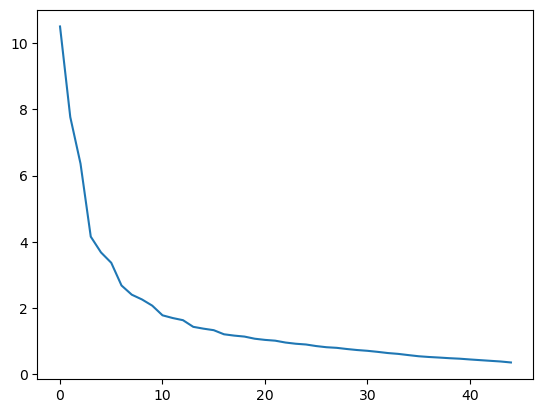

In [23]:
W = torch.randn((batchsize, DIM, DIM), device=device) # represents IID
Y = torch.randn((batchsize,DIM),device=device)
x = torch.zeros((batchsize,DIM),device=device,requires_grad=True)

steps=200
B=BFGS(batchsize,DIM,device)
mem_loss=[]
loss=f(W,Y,x)
acc=1e-6
mem_loss.append(loss.mean())
g=torch.autograd.grad(loss.mean(),x)[0]
d=-torch.matmul(B.H,g.unsqueeze(2))
k=0
#print(loss)
for i in range(steps):
    g_pre=g
    alpha=strong_wolfe(W,Y,batchsize,f, x, d, loss, g, c1=1e-4, c2=0.9, max_iter=10,device=device)
    update=alpha*(d.squeeze())
    x=x+update
    loss=f(W,Y,x)
    mem_loss.append(loss.mean())
    g=torch.autograd.grad(loss.mean(),x)[0]
    #print(torch.norm(g,dim=1).mean())
    if(sum(torch.norm(g,dim=1)<acc)>0):
        break
    d=-torch.matmul(B.H,g.unsqueeze(2))
    #print(B.H)
    B.H_BFDS_update(update,g-g_pre)
    k+=1
    
print(k)    
plt.plot([i.cpu().detach().numpy() for i in mem_loss])  

## LSTM define

In [24]:
class LSTM_motify(torch.nn.Module):
    """LSTM修正器
       LSTM optimizer"""
    
    def __init__(self,input_size,output_size, hidden_size, num_stacks, batchsize,p  = 10 ,preprocess = True, output_scale = 1):
        super(LSTM_motify,self).__init__()
        self.preprocess_flag = preprocess
        self.input_flag = 2
        if preprocess != True:
             self.input_flag = 1
        self.p = p
        self.output_scale = output_scale 
        self.lstm = torch.nn.LSTM(input_size*self.input_flag, hidden_size, num_stacks)
        self.Linear = torch.nn.Linear(hidden_size,output_size) #1-> output_size
        print(self.preprocess_flag)
        
    def LogAndSign_Preprocess_Gradient(self,gradients):
        """
        Args:
          gradients: `Tensor` of gradients with shape `[d_1, ..., d_n]`.
          p       : `p` > 0 is a parameter controlling how small gradients are disregarded 
        Returns:
          `Tensor` with shape `[d_1, ..., d_n-1, 2 * d_n]`. The first `d_n` elements
          along the nth dimension correspond to the `log output` \in [-1,1] and the remaining
          `d_n` elements to the `sign output`.
        """
        p  = self.p
        log = torch.log(torch.abs(gradients))
        clamp_log = torch.clamp(log/p , min = -1.0,max = 1.0)
        clamp_sign = torch.clamp(torch.exp(torch.tensor(p))*gradients, min = -1.0, max =1.0)
        return torch.cat((clamp_log,clamp_sign),dim = -1) #在gradients的最后一维input_dims拼接
    
    def Output_motification_And_motify_LSTM_Hidden_State(self, input_gradients, prev_state):
        """LSTM的核心操作  core operation
        coordinate-wise LSTM """
        if prev_state is None: #init_state
            prev_state = (torch.zeros(Layers,batchsize,Hidden_nums),
                            torch.zeros(Layers,batchsize,Hidden_nums))
            if USE_CUDA :
                 prev_state = (torch.zeros(Layers,batchsize,Hidden_nums).cuda(),
                            torch.zeros(Layers,batchsize,Hidden_nums).cuda())
         			
        motify , next_state = self.lstm(input_gradients, prev_state)
        motify = self.Linear(motify) * self.output_scale # transform the LSTM output to the target output dim 
        return motify, next_state
    
    def forward(self,input_data, prev_state):
        if USE_CUDA:
            input_data = input_data.cuda()
        #pytorch requires the `torch.nn.lstm`'s input as（1，batchsize,input_dim）
        # original gradient.size()=torch.size[5] ->[1,1,5]
        # gradients = move_gradients.unsqueeze(0)
        # moves = move.unsqueeze(0)
        # combined = torch.cat((moves, gradients), dim=0)
        if self.preprocess_flag == True:
            #print(input_data.shape)
            input_data = self.LogAndSign_Preprocess_Gradient(input_data)
        motify , next_state = self.Output_motification_And_motify_LSTM_Hidden_State(input_data , prev_state)
        # Squeeze to make it a single batch again.[1,1,5]->[5]
        motify = motify.squeeze().squeeze()
       
        return motify , next_state

In [25]:
Layers = 2
Hidden_nums = 20
Input_DIM = DIM*2
Output_DIM = DIM**2
output_scale_value=1

#######   构造一个优化器  #######
#######  construct a optimizer  #######
LSTM_motify = LSTM_motify(Input_DIM, Output_DIM, Hidden_nums ,Layers , batchsize=batchsize,\
                preprocess=True,output_scale=output_scale_value)
print(LSTM_motify)

if USE_CUDA:
    LSTM_optimizer = LSTM_motify.cuda()

True
LSTM_motify(
  (lstm): LSTM(40, 20, num_layers=2)
  (Linear): Linear(in_features=20, out_features=100, bias=True)
)


## LSTM pre-train vs BFGS

40
40


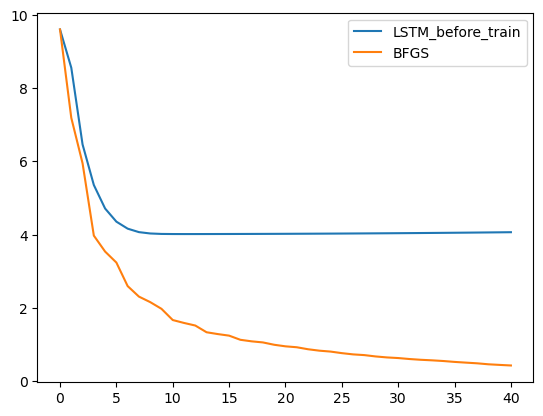

In [26]:
batchsize=128
W = torch.randn((batchsize, DIM, DIM), device=device) # represents IID
Y = torch.randn((batchsize,DIM),device=device)
x = torch.zeros((batchsize,DIM),device=device,requires_grad=True)
steps=40
state=None
H=BFGS(batchsize,DIM,device).I
mem_loss=[]
loss=f(W,Y,x)
acc=1e-6
mem_loss.append(loss.mean())
g=torch.autograd.grad(loss.mean(),x)[0]
d=-torch.matmul(B.H,g.unsqueeze(2))
k=0
#print(loss)
for i in range(steps):
    g_pre=g
    alpha=strong_wolfe(W,Y,batchsize,f, x, d, loss, g, c1=1e-4, c2=0.9, max_iter=10,device=device)
    update=alpha*(d.squeeze())
    x=x+update
    loss=f(W,Y,x)
    mem_loss.append(loss.mean())
    g=torch.autograd.grad(loss.mean(),x)[0]
    #print(torch.norm(g,dim=1).mean())
    if(sum(torch.norm(g,dim=1)<acc)>0):
        break
    d=-torch.matmul(H,g.unsqueeze(2))
    #print(B.H)
    input_vec=torch.cat((g,update),dim=1).unsqueeze(0)
    motify,state=LSTM_motify(input_vec,state)
    delta_H=motify.reshape((batchsize, DIM, DIM))
    H = H.clone().detach() + 1/2*(delta_H+delta_H.transpose(-2,-1))
    k+=1
    
print(k)    
plt.plot([i.cpu().detach().numpy() for i in mem_loss],label='LSTM_before_train')  
x = torch.zeros((batchsize,DIM),device=device,requires_grad=True)
steps=40
B=BFGS(batchsize,DIM,device)
mem_loss=[]
loss=f(W,Y,x)
acc=1e-6
mem_loss.append(loss.mean())
g=torch.autograd.grad(loss.mean(),x)[0]
d=-torch.matmul(B.H,g.unsqueeze(2))
k=0
#print(loss)
for i in range(steps):
    g_pre=g
    alpha=strong_wolfe(W,Y,batchsize,f, x, d, loss, g, c1=1e-4, c2=0.9, max_iter=10,device=device)
    update=alpha*(d.squeeze())
    x=x+update
    loss=f(W,Y,x)
    mem_loss.append(loss.mean())
    g=torch.autograd.grad(loss.mean(),x)[0]
    #print(torch.norm(g,dim=1).mean())
    if(sum(torch.norm(g,dim=1)<acc)>0):
        break
    d=-torch.matmul(B.H,g.unsqueeze(2))
    #print(B.H)
    B.H_BFDS_update(update,g-g_pre)
    k+=1
    
print(k)    
plt.plot([i.cpu().detach().numpy() for i in mem_loss],label='BFGS')  
plt.legend()

plt.show()

## Train LSTM

In [27]:
def RUN(batchsize,DIM,steps=40):    
    
    W = torch.randn((batchsize, DIM, DIM), device=device) # represents IID
    Y = torch.randn((batchsize,DIM),device=device)
    x = torch.zeros((batchsize,DIM),device=device,requires_grad=True)

    state=None#初始化LSTM hidden state
    H=torch.eye(DIM, device=x.device, dtype=x.dtype,requires_grad=True).unsqueeze(0).expand(batchsize, -1, -1)
    mem_loss=[]#初始化loss的list
    loss=f(W,Y,x)#每个case的loss
    global_loss_graph = 0#记录每个迭代的总loss 用于后向传播
    lossmean=loss.mean()#总loss的平均值

    global_loss_graph+=lossmean
    mem_loss.append(lossmean.clone().detach())

    lossmean.backward(retain_graph=True)
    g = x.grad.clone().detach()#g detach掉
    d=-torch.matmul(H,g.unsqueeze(2))
    k=0
    #print(loss)
    for i in range(steps):
        g_pre=g.clone()# 保存g作为上一次的g，此时g_pre不在计算图中
        alpha=strong_wolfe(W,Y,batchsize,f, x, d, loss, g, c1=1e-4, c2=0.9, max_iter=10,device=device)
        alpha.detach_()
        update=alpha*d.squeeze()
        #update=d.squeeze()
        x=x.clone().detach()+update
        x.retain_grad()
        loss=f(W,Y,x)
        lossmean=loss.mean()
        global_loss_graph+=lossmean
        mem_loss.append(lossmean.clone().detach())
        #print(mem_loss[0])
        lossmean.backward(retain_graph=True)
        #print([i.grad for i in LSTM_motify.parameters()])
        g = x.grad.clone().detach()
        #print(torch.norm(g,dim=1).mean())
        if(sum(torch.norm(g,dim=1)<acc)>0):
            break
        #print(B.H)
        input_vec=torch.cat((g,update),dim=1).unsqueeze(0)
        #print(input_vec.is_leaf)
        motify,state=LSTM_motify(input_vec,state)
        H = H.clone() + motify.reshape((batchsize, DIM, DIM))
        H.retain_grad()
        d=-torch.matmul(H,g.unsqueeze(2))
        k+=1
    plt.plot([i.cpu().detach().numpy() for i in mem_loss],label='LSTM_before_train')
    #

    return mem_loss,global_loss_graph

In [28]:
def global_training(Global_Train_Steps,motifier):
    global_loss_list = []    
    adam_global_optimizer = torch.optim.Adam(motifier.parameters(),lr = 0.0001)
    _,global_loss_1 = RUN(batchsize,DIM,steps=40)
    print(global_loss_1)
    for i in range(Global_Train_Steps):    
        _,global_loss = RUN(batchsize,DIM,steps=40)      
        adam_global_optimizer.zero_grad()
        print(i,global_loss)
        global_loss.backward() #每次都是优化这个固定的图，不可以释放动态图的缓存
        #print('xxx',[z.shape for z in motifier.parameters()  ])
        adam_global_optimizer.step()
        #print('xxx',[(z.grad,z.requires_grad) for z in motifier.parameters()  ])
        global_loss_list.append(global_loss.detach_())
        
    print(global_loss)
    return global_loss_list


tensor(187.7901, device='cuda:0', grad_fn=<AddBackward0>)
0 tensor(196.1333, device='cuda:0', grad_fn=<AddBackward0>)
1 tensor(199.9740, device='cuda:0', grad_fn=<AddBackward0>)
2 tensor(204.7379, device='cuda:0', grad_fn=<AddBackward0>)
3 tensor(190.5445, device='cuda:0', grad_fn=<AddBackward0>)
4 tensor(191.3557, device='cuda:0', grad_fn=<AddBackward0>)
5 tensor(214.0848, device='cuda:0', grad_fn=<AddBackward0>)
6 tensor(194.6532, device='cuda:0', grad_fn=<AddBackward0>)
7 tensor(193.3459, device='cuda:0', grad_fn=<AddBackward0>)
8 tensor(197.5514, device='cuda:0', grad_fn=<AddBackward0>)
9 tensor(174.2658, device='cuda:0', grad_fn=<AddBackward0>)
10 tensor(199.2298, device='cuda:0', grad_fn=<AddBackward0>)
11 tensor(178.8573, device='cuda:0', grad_fn=<AddBackward0>)
12 tensor(190.5185, device='cuda:0', grad_fn=<AddBackward0>)
13 tensor(182.8314, device='cuda:0', grad_fn=<AddBackward0>)
14 tensor(185.0486, device='cuda:0', grad_fn=<AddBackward0>)
15 tensor(185.7025, device='cuda:0', 

[tensor(196.1333, device='cuda:0'),
 tensor(199.9740, device='cuda:0'),
 tensor(204.7379, device='cuda:0'),
 tensor(190.5445, device='cuda:0'),
 tensor(191.3557, device='cuda:0'),
 tensor(214.0848, device='cuda:0'),
 tensor(194.6532, device='cuda:0'),
 tensor(193.3459, device='cuda:0'),
 tensor(197.5514, device='cuda:0'),
 tensor(174.2658, device='cuda:0'),
 tensor(199.2298, device='cuda:0'),
 tensor(178.8573, device='cuda:0'),
 tensor(190.5185, device='cuda:0'),
 tensor(182.8314, device='cuda:0'),
 tensor(185.0486, device='cuda:0'),
 tensor(185.7025, device='cuda:0'),
 tensor(207.9495, device='cuda:0'),
 tensor(206.7970, device='cuda:0'),
 tensor(175.1815, device='cuda:0'),
 tensor(203.3649, device='cuda:0'),
 tensor(199.9261, device='cuda:0'),
 tensor(188.9105, device='cuda:0'),
 tensor(178.1756, device='cuda:0'),
 tensor(176.2849, device='cuda:0'),
 tensor(200.0173, device='cuda:0'),
 tensor(183.7766, device='cuda:0'),
 tensor(185.1156, device='cuda:0'),
 tensor(196.4415, device='cu

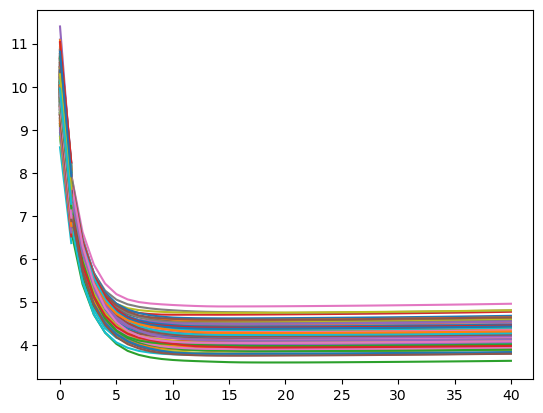

In [29]:
global_training(500,LSTM_motify)

## LSTM-BFGS vs BFGS

tensor([[ 0.0095,  0.0209,  0.0373,  ..., -0.0477,  0.0511,  0.0249],
        [-0.0310, -0.0344,  0.0181,  ..., -0.0188, -0.0515,  0.0041],
        [ 0.0559,  0.0858, -0.0470,  ..., -0.0356,  0.0210,  0.0488],
        ...,
        [ 0.1632,  0.0711, -0.1177,  ..., -0.1129, -0.0819, -0.1188],
        [ 0.0630, -0.0433, -0.0193,  ..., -0.0173,  0.0076, -0.0497],
        [-0.0700, -0.0649, -0.0302,  ...,  0.0181,  0.0558, -0.0894]],
       device='cuda:0')
tensor([[-0.0050,  0.0022,  0.0431,  ..., -0.0152,  0.0243,  0.0144],
        [-0.0212, -0.0298,  0.0079,  ..., -0.0217, -0.0373,  0.0095],
        [ 0.0319,  0.0408, -0.0366,  ..., -0.0200,  0.0036,  0.0202],
        ...,
        [ 0.0584,  0.0270, -0.0378,  ..., -0.0854, -0.0389, -0.0867],
        [ 0.0292, -0.0415, -0.0109,  ..., -0.0162, -0.0028, -0.0303],
        [-0.0369, -0.0364, -0.0150,  ...,  0.0311,  0.0405, -0.0456]],
       device='cuda:0')
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan

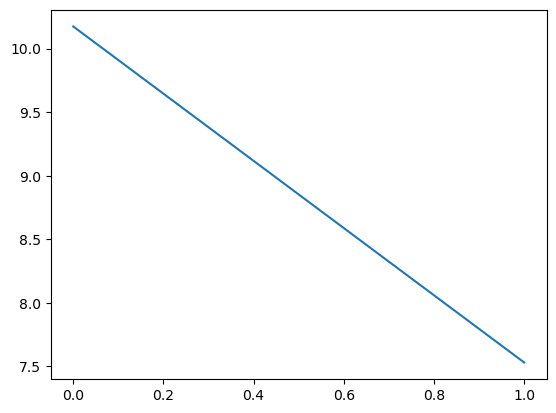

In [30]:
W = torch.randn((batchsize, DIM, DIM), device=device) # represents IID
Y = torch.randn((batchsize,DIM),device=device)
x = torch.zeros((batchsize,DIM),device=device,requires_grad=True)

state=None#初始化LSTM hidden state
H=torch.eye(DIM, device=x.device, dtype=x.dtype,requires_grad=True).unsqueeze(0).expand(batchsize, -1, -1)
steps=20
mem_loss=[]#初始化loss的list
loss=f(W,Y,x)#每个case的loss
global_loss_graph = 0#记录每个迭代的总loss 用于后向传播
lossmean=loss.mean()#总loss的平均值

global_loss_graph+=lossmean
mem_loss.append(lossmean.clone().detach())

lossmean.backward(retain_graph=True)
g = x.grad.clone().detach()#g detach掉
d=-torch.matmul(H,g.unsqueeze(2))
k=0
#print(loss)
for i in range(steps):
    g_pre=g.clone()# 保存g作为上一次的g，此时g_pre不在计算图中
    # alpha=strong_wolfe(W,Y,batchsize,f, x, d, loss, g, c1=1e-4, c2=0.9, max_iter=10,device=device)
    # alpha.detach_()
    # update=alpha*d.squeeze()
    update=d.squeeze()
    x=x.clone().detach()+update
    x.retain_grad()
    loss=f(W,Y,x)
    lossmean=loss.mean()
    global_loss_graph+=lossmean
    mem_loss.append(lossmean.clone().detach())
    #print(mem_loss[0])
    lossmean.backward(retain_graph=True)
    #print([i.grad for i in LSTM_motify.parameters()])
    print(g)
    g = x.grad.clone().detach()
    #print(torch.norm(g,dim=1).mean())
    if(sum(torch.norm(g,dim=1)<acc)>0):
        break
    #print(B.H)
    input_vec=torch.cat((g,update),dim=1).unsqueeze(0)
    #print(input_vec.is_leaf)
    motify,state=LSTM_motify(input_vec,state)
    H = H.clone() + motify.reshape((batchsize, DIM, DIM))
    H.retain_grad()
    d=-torch.matmul(H,g.unsqueeze(2))
    k+=1
plt.plot([i.cpu().detach().numpy() for i in mem_loss],label='LSTM_before_train')